In [1]:
# General
import math, json, collections, itertools
import os
import pandas as pd
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Network analysis
import networkx as nx

# Visual
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Specify the path to the project root directory
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

# Import custom module src
import src.utils as utils

### Steps:
1. Read data.
2. Basic EDA.
3. Prepare data.\
3.1. Create matrix.\
3.2. Count matches between directors.
4. Create graph.
5. Create and plot subgraph.
6. Answer network related questions. \
6.1. Graph related question. \
6.2. Node specific questions.
7. Updated graph.

## 1. Read data

In [2]:
os.listdir('../data')

['US_Directors_favourite_movies.xls']

In [3]:
df_us_directors = pd.read_excel('../data/US_Directors_favourite_movies.xls')
df_us_directors

,Director,Movie,Year,Movie's director
0,Woody Allen,"400 Blows, The",1959,François Truffaut
1,Woody Allen,8½,1963,Federico Fellini
2,Woody Allen,Amarcord,1972,Federico Fellini
3,Woody Allen,"Bicycle Thieves, The",1948,Vittorio de Sica
4,Woody Allen,Citizen Kane,1941,Orson Welles
...,...,...,...,...
471,Steven Soderbergh,"The 5,000 Fingers of Dr. T",1953,Roy Rowland
472,Steven Soderbergh,The Conversation,1974,Francis Ford Coppola
473,Steven Soderbergh,Citizen Kane,1941,Orson Welles
474,Steven Soderbergh,Annie Hall,1977,Woody Allen


### 2. Basic EDA (Exploratory Data Analysis)

In [4]:
df_us_directors['Director'].nunique()

47

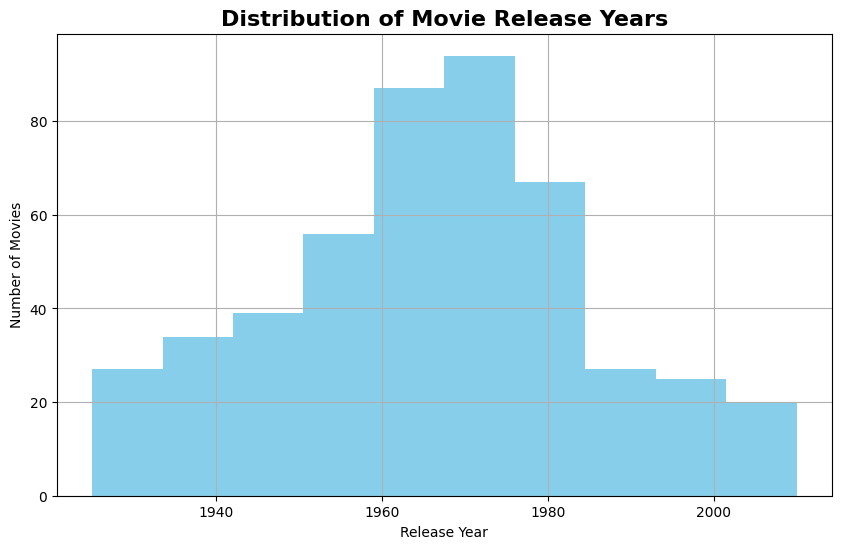

In [5]:
plt.figure(figsize=(10, 6))

# Plot histogram
df_us_directors['Year'].hist(color='skyblue')

# Add title and axis labels
plt.title('Distribution of Movie Release Years',fontsize=16, fontweight='bold')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')

plt.savefig('../images/US_Directors_favorites_hist.png')

In [6]:
df_us_directors['Movie'].nunique()

351

In [7]:
median_year = int(df_us_directors['Year'].median())
print(f"Median Year: {median_year}, distance from median year to year of poll: {2012 - median_year}")

Median Year: 1967, distance from median year to year of poll: 45


In [8]:
df_us_directors['Movie'].value_counts()[:10]

Movie
Citizen Kane               8
Vertigo                    7
Jaws                       6
2001: A Space Odyssey      6
8½                         6
Lawrence of Arabia         6
Godfather: Part II, The    4
400 Blows, The             4
Tokyo Story                4
Barry Lyndon               4
Name: count, dtype: int64

5 out of 10 - overlaps with global top-10 for 2012

In [9]:
global_top_10 = ['Vertigo', 'Citizen Kane', 'Tokyo Story', 
                 '8½', 'Taxi Driver', 'Apocalypse Now', '2001: A Space Odyssey', 
                 'Bycicle Thieves', 'Mirror', 'Godfather: Part II, The']
df_us_top10 = pd.DataFrame(df_us_directors['Movie'].value_counts()[:10]).reset_index().rename(columns={'count': 'Votes'})
df_us_top10['IsInGlobalTop10'] = df_us_top10['Movie'].isin(global_top_10)
df_us_top10

,Movie,Votes,IsInGlobalTop10
0,Citizen Kane,8,True
1,Vertigo,7,True
2,Jaws,6,False
3,2001: A Space Odyssey,6,True
4,8½,6,True
5,Lawrence of Arabia,6,False
6,"Godfather: Part II, The",4,True
7,"400 Blows, The",4,False
8,Tokyo Story,4,True
9,Barry Lyndon,4,False


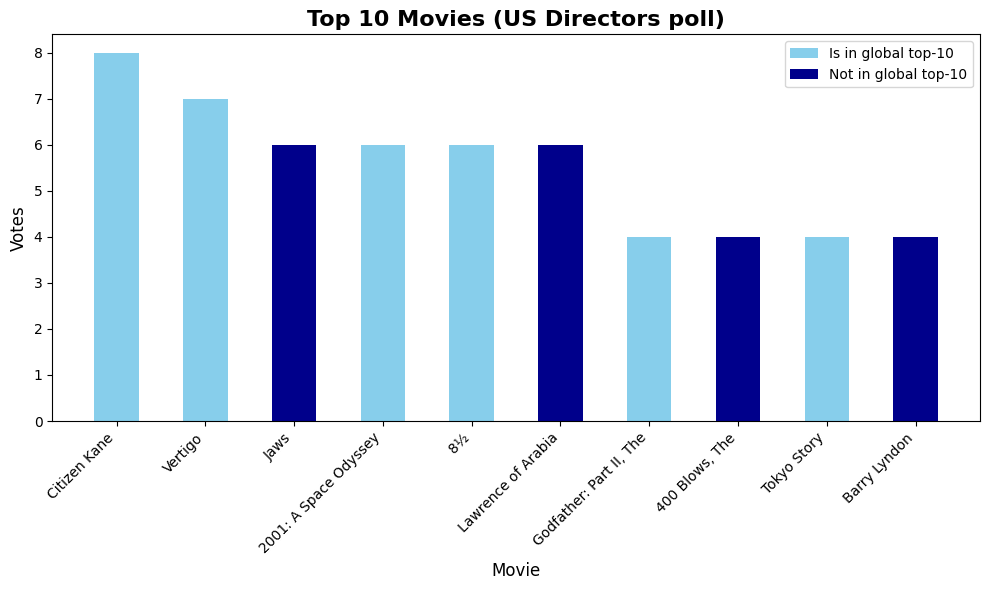

In [10]:
colors = ['skyblue' if flag else 'darkblue' for flag in df_us_top10["IsInGlobalTop10"]]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_us_top10["Movie"], df_us_top10["Votes"], color=colors, width=.5)

# Labels & title
ax.set_title("Top 10 Movies (US Directors poll)", fontsize=16, fontweight='bold')
ax.set_xlabel("Movie", fontsize=12)
ax.set_ylabel("Votes", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Legend handles
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', label='Is in global top-10'),
    Patch(facecolor='darkblue', label='Not in global top-10')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

Insights: 
* There are 351 distinct movies mentioned by 47 US directors in the poll. 
* Median release year across movies - 1967.
* 60% of US directors top-10 overlaps with global directors poll.
* "Jaws" and "Lawrence of Arabia" are leaders specific to US region. 
* Global 2012 director poll leader "Tokyo Story" is N9 here, while top-4 are all american.

Interpretation: \
This surface level analysis confirms there is some shared inspiration, but also some specific to the US region.

## 3. Prepare data
Prepare dataset for the network analysis by building matrix of shared inspiration movies across all US directors.

## 3.1. Create matrix

In [11]:
Directors_US=[]
for i in range(len(df_us_directors)):
    if df_us_directors.iloc[i,0] not in Directors_US:
        Directors_US.append(df_us_directors.iloc[i,0])
Directors_US=[d[:-1] if d[-1]==' ' else d for d in Directors_US ]
Directors_US

['Woody Allen',
 'Thom Andersen',
 'Gregg Araki',
 'Henry Bean',
 'Charles Burnett',
 'Antonio Campos',
 'Joseph Cedar',
 'Francis Ford Coppola',
 'Sara Driver',
 'Jay Duplass',
 'Sean Durkin',
 'Abel Ferrara',
 'Morgan Fisher',
 'Robert Gardner',
 'John Gianvito',
 'Monte Hellman',
 'William E Jones',
 'Miranda July',
 'Lawrence Kasdan',
 'Aaron Katz',
 'Lloyd Kaufman',
 'Lodge Kerrigan',
 'Richard Lester',
 'Michael Mann',
 'John McNaughton',
 'Sam Mendes',
 'Greg Mottola',
 'Jeff Nichols',
 'Amos Poe',
 'Mark Romanek',
 'David O. Russell',
 'Ira Sachs',
 'Benjamin Safdie',
 'Josh Safdie',
 'Paul Schrader',
 'Martin Scorsese',
 'Allan Sekula',
 'Whit Stillman',
 'Joe Swanberg',
 'Quentin Tarantino',
 'Marc Webb',
 'Billy Woodberry',
 'Steven Spielberg',
 'Christopher Nolan',
 'David Fincher',
 'Paul Thomas Anderson',
 'Steven Soderbergh']

In [12]:
Directors_choice_US=utils.Director_full_choice(df_us_directors)
Directors_choice_US

{'Woody Allen': [('400 Blows, The', 1959, 'François Truffaut'),
  ('8½', 1963, 'Federico Fellini'),
  ('Amarcord', 1972, 'Federico Fellini'),
  ('Bicycle Thieves, The', 1948, 'Vittorio de Sica'),
  ('Citizen Kane', 1941, 'Orson Welles'),
  ('Discreet Charm of the Bourgeoisie, The', 1972, 'Luis Buñuel'),
  ('grande illusion, La', 1937, 'Jean Renoir'),
  ('Paths of Glory', 1957, 'Stanley Kubrick'),
  ('Rashomon', 1950, 'Akira Kurosawa'),
  ('Seventh Seal, The', 1957, 'Ingmar Bergman')],
 'Thom Andersen': [("God's Step Children", 1938, 'Oscar Micheaux'),
  ('High and Low', 1963, 'Akira Kurosawa'),
  ('Hour of the Furnaces, The', 1968, 'Octavio Getino/Fernando E. Solanas'),
  ('Kiss Me Deadly', 1955, 'Robert Aldrich'),
  ('My Darling Clementine', 1946, 'John Ford'),
  ('Not Reconciled', 1965, 'Jean-Marie Straub/Danièle Huillet'),
  ('Perceval', 1978, 'Eric Rohmer'),
  ('Pickpocket', 1959, 'Robert Bresson'),
  ('Puppetmaster, The', 1993, 'Hsiao-hsien Hou'),
  ('Tokyo Story', 1953, 'Ozu Yasu

## 3.2. Count matches between directors

In [13]:
matr=utils.matrix_init(Directors_US)
matr

,Woody Allen,Thom Andersen,Gregg Araki,Henry Bean,Charles Burnett,Antonio Campos,Joseph Cedar,Francis Ford Coppola,Sara Driver,Jay Duplass,...,Whit Stillman,Joe Swanberg,Quentin Tarantino,Marc Webb,Billy Woodberry,Steven Spielberg,Christopher Nolan,David Fincher,Paul Thomas Anderson,Steven Soderbergh
Woody Allen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thom Andersen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gregg Araki,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Henry Bean,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charles Burnett,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Antonio Campos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Joseph Cedar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Francis Ford Coppola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sara Driver,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jay Duplass,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
all_directors = list(matr.index)

In [15]:
def count_common(poll: dict, name1: str, name2: str) -> int:
    """Count the number of common movies between two directors.

    Args:
        poll (dict): Mapping of directors to their 10 selected movies.
        name1 (str): First director's name.
        name2 (str): Second director's name.

    Returns:
        int: Number of common movies between the two directors.
    """
    list1=[line[0] for line in poll[name1]] 
    list2=[line[0] for line in poll[name2]] 
    count=len(set(list1).intersection(list2))
    return count

In [16]:
for i in range(len(all_directors)):
    for j in range(i+1,len(all_directors)):
        matr.loc[all_directors[i]][all_directors[j]]=matr.loc[all_directors[j]][all_directors[i]]=count_common(Directors_choice_US,all_directors[i],all_directors[j])

In [17]:
matr

,Woody Allen,Thom Andersen,Gregg Araki,Henry Bean,Charles Burnett,Antonio Campos,Joseph Cedar,Francis Ford Coppola,Sara Driver,Jay Duplass,...,Whit Stillman,Joe Swanberg,Quentin Tarantino,Marc Webb,Billy Woodberry,Steven Spielberg,Christopher Nolan,David Fincher,Paul Thomas Anderson,Steven Soderbergh
Woody Allen,0,0,0,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,1,0,1
Thom Andersen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gregg Araki,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Henry Bean,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
Charles Burnett,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Antonio Campos,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Joseph Cedar,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
Francis Ford Coppola,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
Sara Driver,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jay Duplass,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Create graph

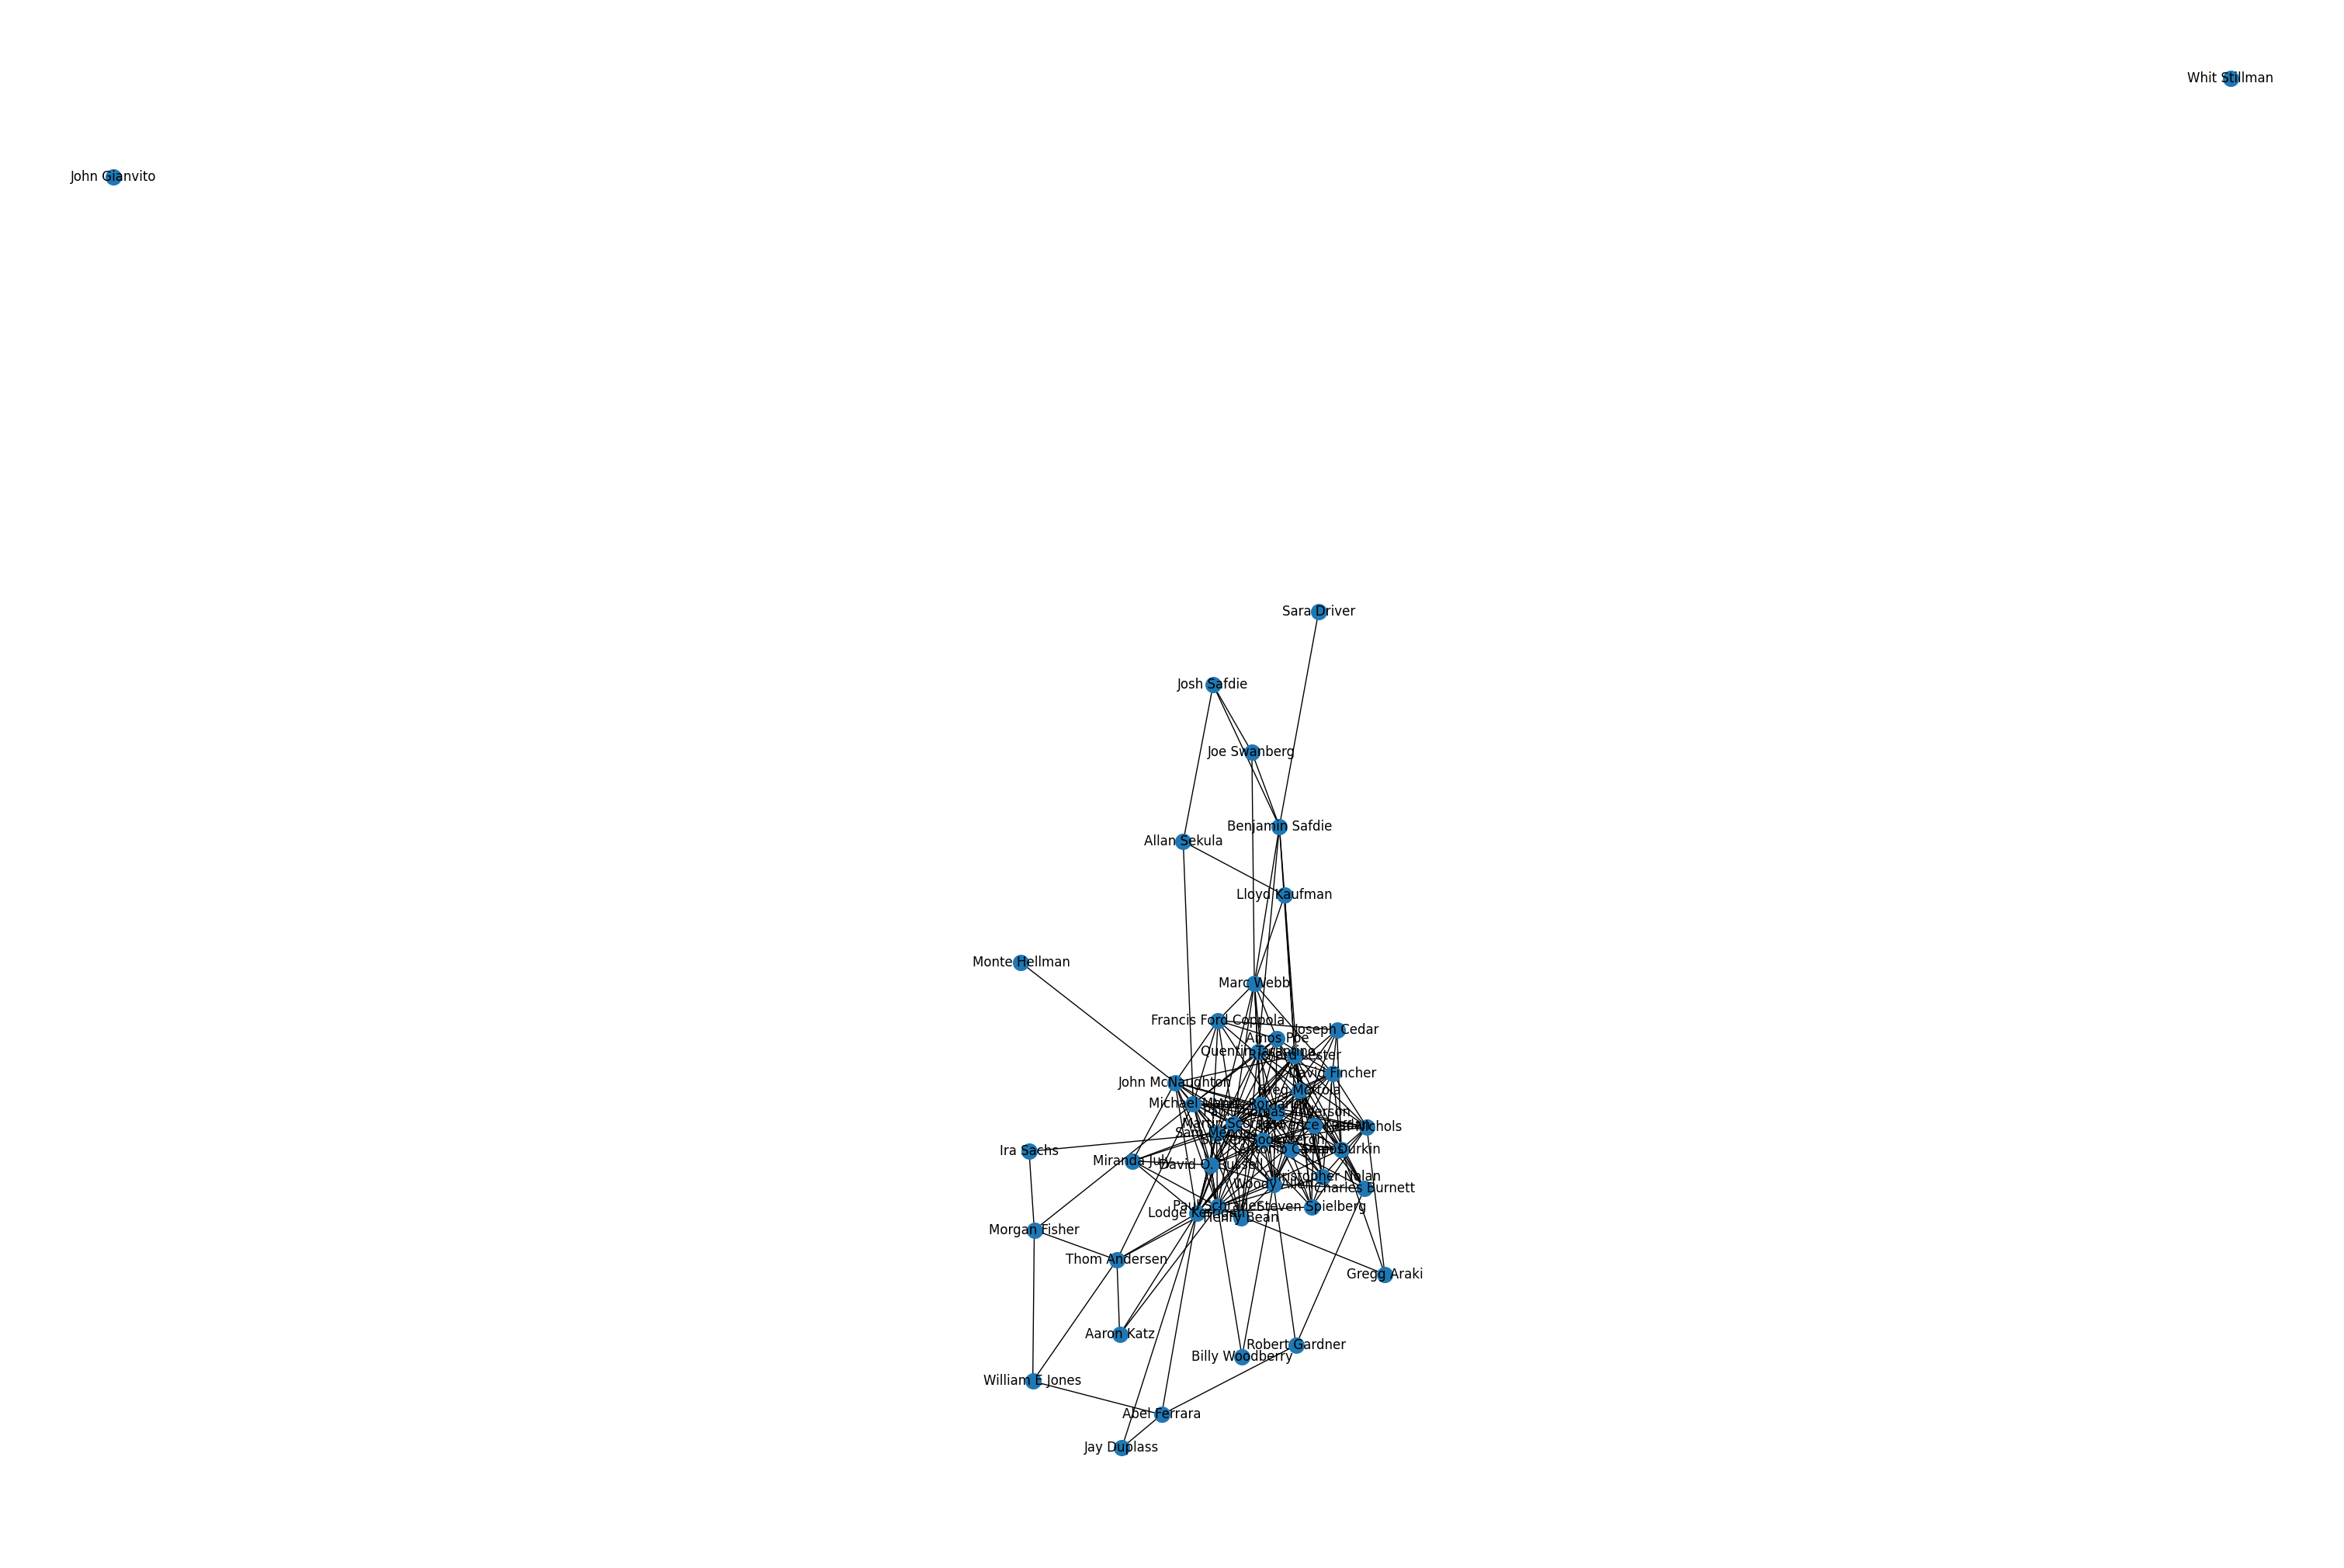

In [18]:
G1 = nx.Graph(matr)

plt.figure(figsize=(30, 20)) 
nx.draw(G1,node_size=200,with_labels=True)
plt.show()

### 5. Create and plot subgraph

In [60]:
def show_subgraph(matrix: pd.DataFrame, directors: list) -> None:
    """Create and display a subgraph for a given list of directors."""
    submatr = matrix.loc[directors, directors]
    G = nx.Graph(submatr)
    
    plt.figure(figsize=(5,5)) 
    pos = nx.spring_layout(G, k=0.03, seed=5)
    
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    node_colors = ['grey' if node in directors else '#33a02c' for node in G.nodes()]
    
    nx.draw(
        G,
        pos,
        node_size=200,
        node_color=node_colors,
        edge_color='gray',
        width=[w * 2 for w in edge_weights],
        with_labels=False  # Turn off default labels
    )

    nx.draw_networkx_labels(
        G,
        pos,
        font_size=7,
        font_color='black',
        verticalalignment='center',
        horizontalalignment='center'
    )
    
    plt.title("Subgraph of Selected Directors", pad=20)
    plt.tight_layout(pad=3)
    plt.savefig('../images/US_directors_subgraph.png', dpi=300, bbox_inches='tight')
    plt.show()


In [61]:
def show_overlap_movies(voting: dict, directors: list) -> None:
    """Display common movies between selected directors."""
    print("Overlapping influence between selected directors:")
    for i in range(len(directors)):
        for j in range(i + 1, len(directors)):
            common_movies = set(voting[directors[i]]) & set(voting[directors[j]])
            print(f"Common influence for {directors[i]} and {directors[j]}")
            print(common_movies)

C:\Users\yurii\AppData\Local\Temp\ipykernel_20604\250284058.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3)


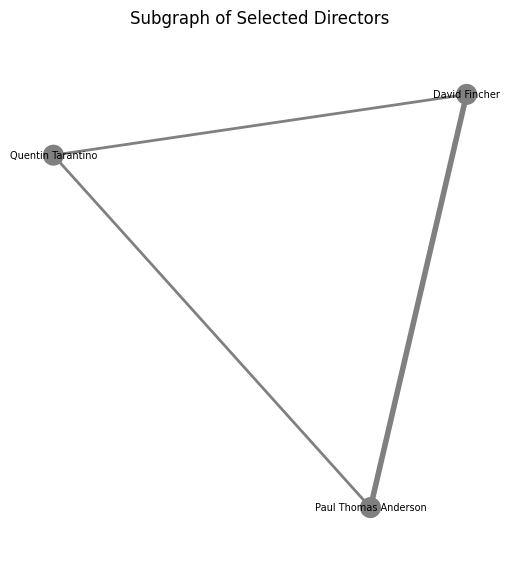

Overlapping influence between selected directors:
Common influence for Quentin Tarantino and David Fincher
{('Jaws', 1975, 'Steven Spielberg')}
Common influence for Quentin Tarantino and Paul Thomas Anderson
{('Jaws', 1975, 'Steven Spielberg')}
Common influence for David Fincher and Paul Thomas Anderson
{('Jaws', 1975, 'Steven Spielberg'), ('Rear Window', 1954, 'Alfred Hitchcock')}


In [62]:
dir_list = ['Quentin Tarantino', 'David Fincher', 'Paul Thomas Anderson']
show_subgraph(matr, dir_list)
show_overlap_movies(Directors_choice_US, dir_list)

### 6. Answer network related questions

### 6.1. Graph related questions
- Beta index;
- Vertex/edge connectivity.

In [28]:
# Number of edges (E), number of nodes (V)
E = G1.number_of_edges()
V = G1.number_of_nodes()

# Compute beta index: β = E / V
beta_index = E / V if V > 0 else 0

# Output the results
print(f"Beta Index: {beta_index:.2f}")

Beta Index: 4.36


Interpretation: \
Highly Interconnected Network. \
Each director is, on average, connected to many others — not isolated creators.
4.36 means: Each director is part of ~4-5 inspiration overlaps, on average.

### 6.2. Node specific questions
Who is the most connected director? \
Who connects different communities within a full network of the American filmmakers?

In [29]:
degree_centr = nx.degree_centrality(G1)
between_centr = nx.betweenness_centrality(G1)
print('Degree centrality : ',degree_centr)
print('Betweenness centrality : ',between_centr)

Degree centrality :  {'Woody Allen': 0.3695652173913043, 'Thom Andersen': 0.13043478260869565, 'Gregg Araki': 0.06521739130434782, 'Henry Bean': 0.17391304347826086, 'Charles Burnett': 0.17391304347826086, 'Antonio Campos': 0.19565217391304346, 'Joseph Cedar': 0.13043478260869565, 'Francis Ford Coppola': 0.19565217391304346, 'Sara Driver': 0.021739130434782608, 'Jay Duplass': 0.043478260869565216, 'Sean Durkin': 0.2608695652173913, 'Abel Ferrara': 0.08695652173913043, 'Morgan Fisher': 0.08695652173913043, 'Robert Gardner': 0.06521739130434782, 'John Gianvito': 0.0, 'Monte Hellman': 0.021739130434782608, 'William E Jones': 0.06521739130434782, 'Miranda July': 0.13043478260869565, 'Lawrence Kasdan': 0.2391304347826087, 'Aaron Katz': 0.06521739130434782, 'Lloyd Kaufman': 0.10869565217391304, 'Lodge Kerrigan': 0.3695652173913043, 'Richard Lester': 0.32608695652173914, 'Michael Mann': 0.3695652173913043, 'John McNaughton': 0.2826086956521739, 'Sam Mendes': 0.3913043478260869, 'Greg Mottola'

In [30]:
{k: v for k, v in sorted(between_centr.items(), key=lambda item: item[1], reverse=True)}
#Lodge Kerrigan - touchstone of american cinema

{'Lodge Kerrigan': 0.12874543926071053,
 'Michael Mann': 0.10332544277845698,
 'Benjamin Safdie': 0.07140188045985148,
 'Woody Allen': 0.069087953108041,
 'Marc Webb': 0.06775363299581452,
 'Sam Mendes': 0.06469989826804379,
 'Richard Lester': 0.06131237995704743,
 'Paul Schrader': 0.05965959905378122,
 'John McNaughton': 0.05173636504558763,
 'Quentin Tarantino': 0.04294599237275269,
 'Martin Scorsese': 0.03809304748239886,
 'David O. Russell': 0.030206724364420557,
 'Mark Romanek': 0.029197649427089672,
 'Thom Andersen': 0.028185886372160893,
 'Greg Mottola': 0.026708206804825167,
 'Steven Soderbergh': 0.026523096048337323,
 'Paul Thomas Anderson': 0.02400001263523297,
 'Sean Durkin': 0.020169103772270863,
 'Allan Sekula': 0.015621825839217144,
 'Abel Ferrara': 0.015471779136527645,
 'Jeff Nichols': 0.012241431537831726,
 'Charles Burnett': 0.0122059387175485,
 'Morgan Fisher': 0.011813680107584624,
 'Lawrence Kasdan': 0.010663826901418632,
 'David Fincher': 0.010636086370799658,
 'L

In [31]:
{k: v for k, v in sorted(degree_centr.items(), key=lambda item: item[1], reverse=True)}


{'Martin Scorsese': 0.43478260869565216,
 'Sam Mendes': 0.3913043478260869,
 'Mark Romanek': 0.3913043478260869,
 'Steven Soderbergh': 0.3913043478260869,
 'Woody Allen': 0.3695652173913043,
 'Lodge Kerrigan': 0.3695652173913043,
 'Michael Mann': 0.3695652173913043,
 'Paul Schrader': 0.34782608695652173,
 'Richard Lester': 0.32608695652173914,
 'Paul Thomas Anderson': 0.32608695652173914,
 'David O. Russell': 0.30434782608695654,
 'John McNaughton': 0.2826086956521739,
 'Greg Mottola': 0.2826086956521739,
 'Sean Durkin': 0.2608695652173913,
 'Quentin Tarantino': 0.2608695652173913,
 'David Fincher': 0.2608695652173913,
 'Lawrence Kasdan': 0.2391304347826087,
 'Jeff Nichols': 0.2391304347826087,
 'Marc Webb': 0.2391304347826087,
 'Amos Poe': 0.21739130434782608,
 'Christopher Nolan': 0.21739130434782608,
 'Antonio Campos': 0.19565217391304346,
 'Francis Ford Coppola': 0.19565217391304346,
 'Steven Spielberg': 0.19565217391304346,
 'Henry Bean': 0.17391304347826086,
 'Charles Burnett': 0

In [32]:
most_connected = [k for k, v in sorted(degree_centr.items(), key=lambda item: item[1], reverse=True)][0]
most_connected

'Martin Scorsese'

In [33]:
community_connector = [k for k, v in sorted(between_centr.items(), key=lambda item: item[1], reverse=True)][0]
community_connector

'Lodge Kerrigan'

In [34]:
disconnected =[k for k, v in degree_centr.items() if v < .000001]
disconnected

['John Gianvito', 'Whit Stillman']

### 7. Updated graph
Display only connected nodes. 

Color-coding:
- most-connected: Pale Turquoise.
- community-connector: Light Coral.

In [35]:
matr_2 = matr.drop(columns=disconnected, index=disconnected)
matr_2.shape

(45, 45)

Simple unweighted edges

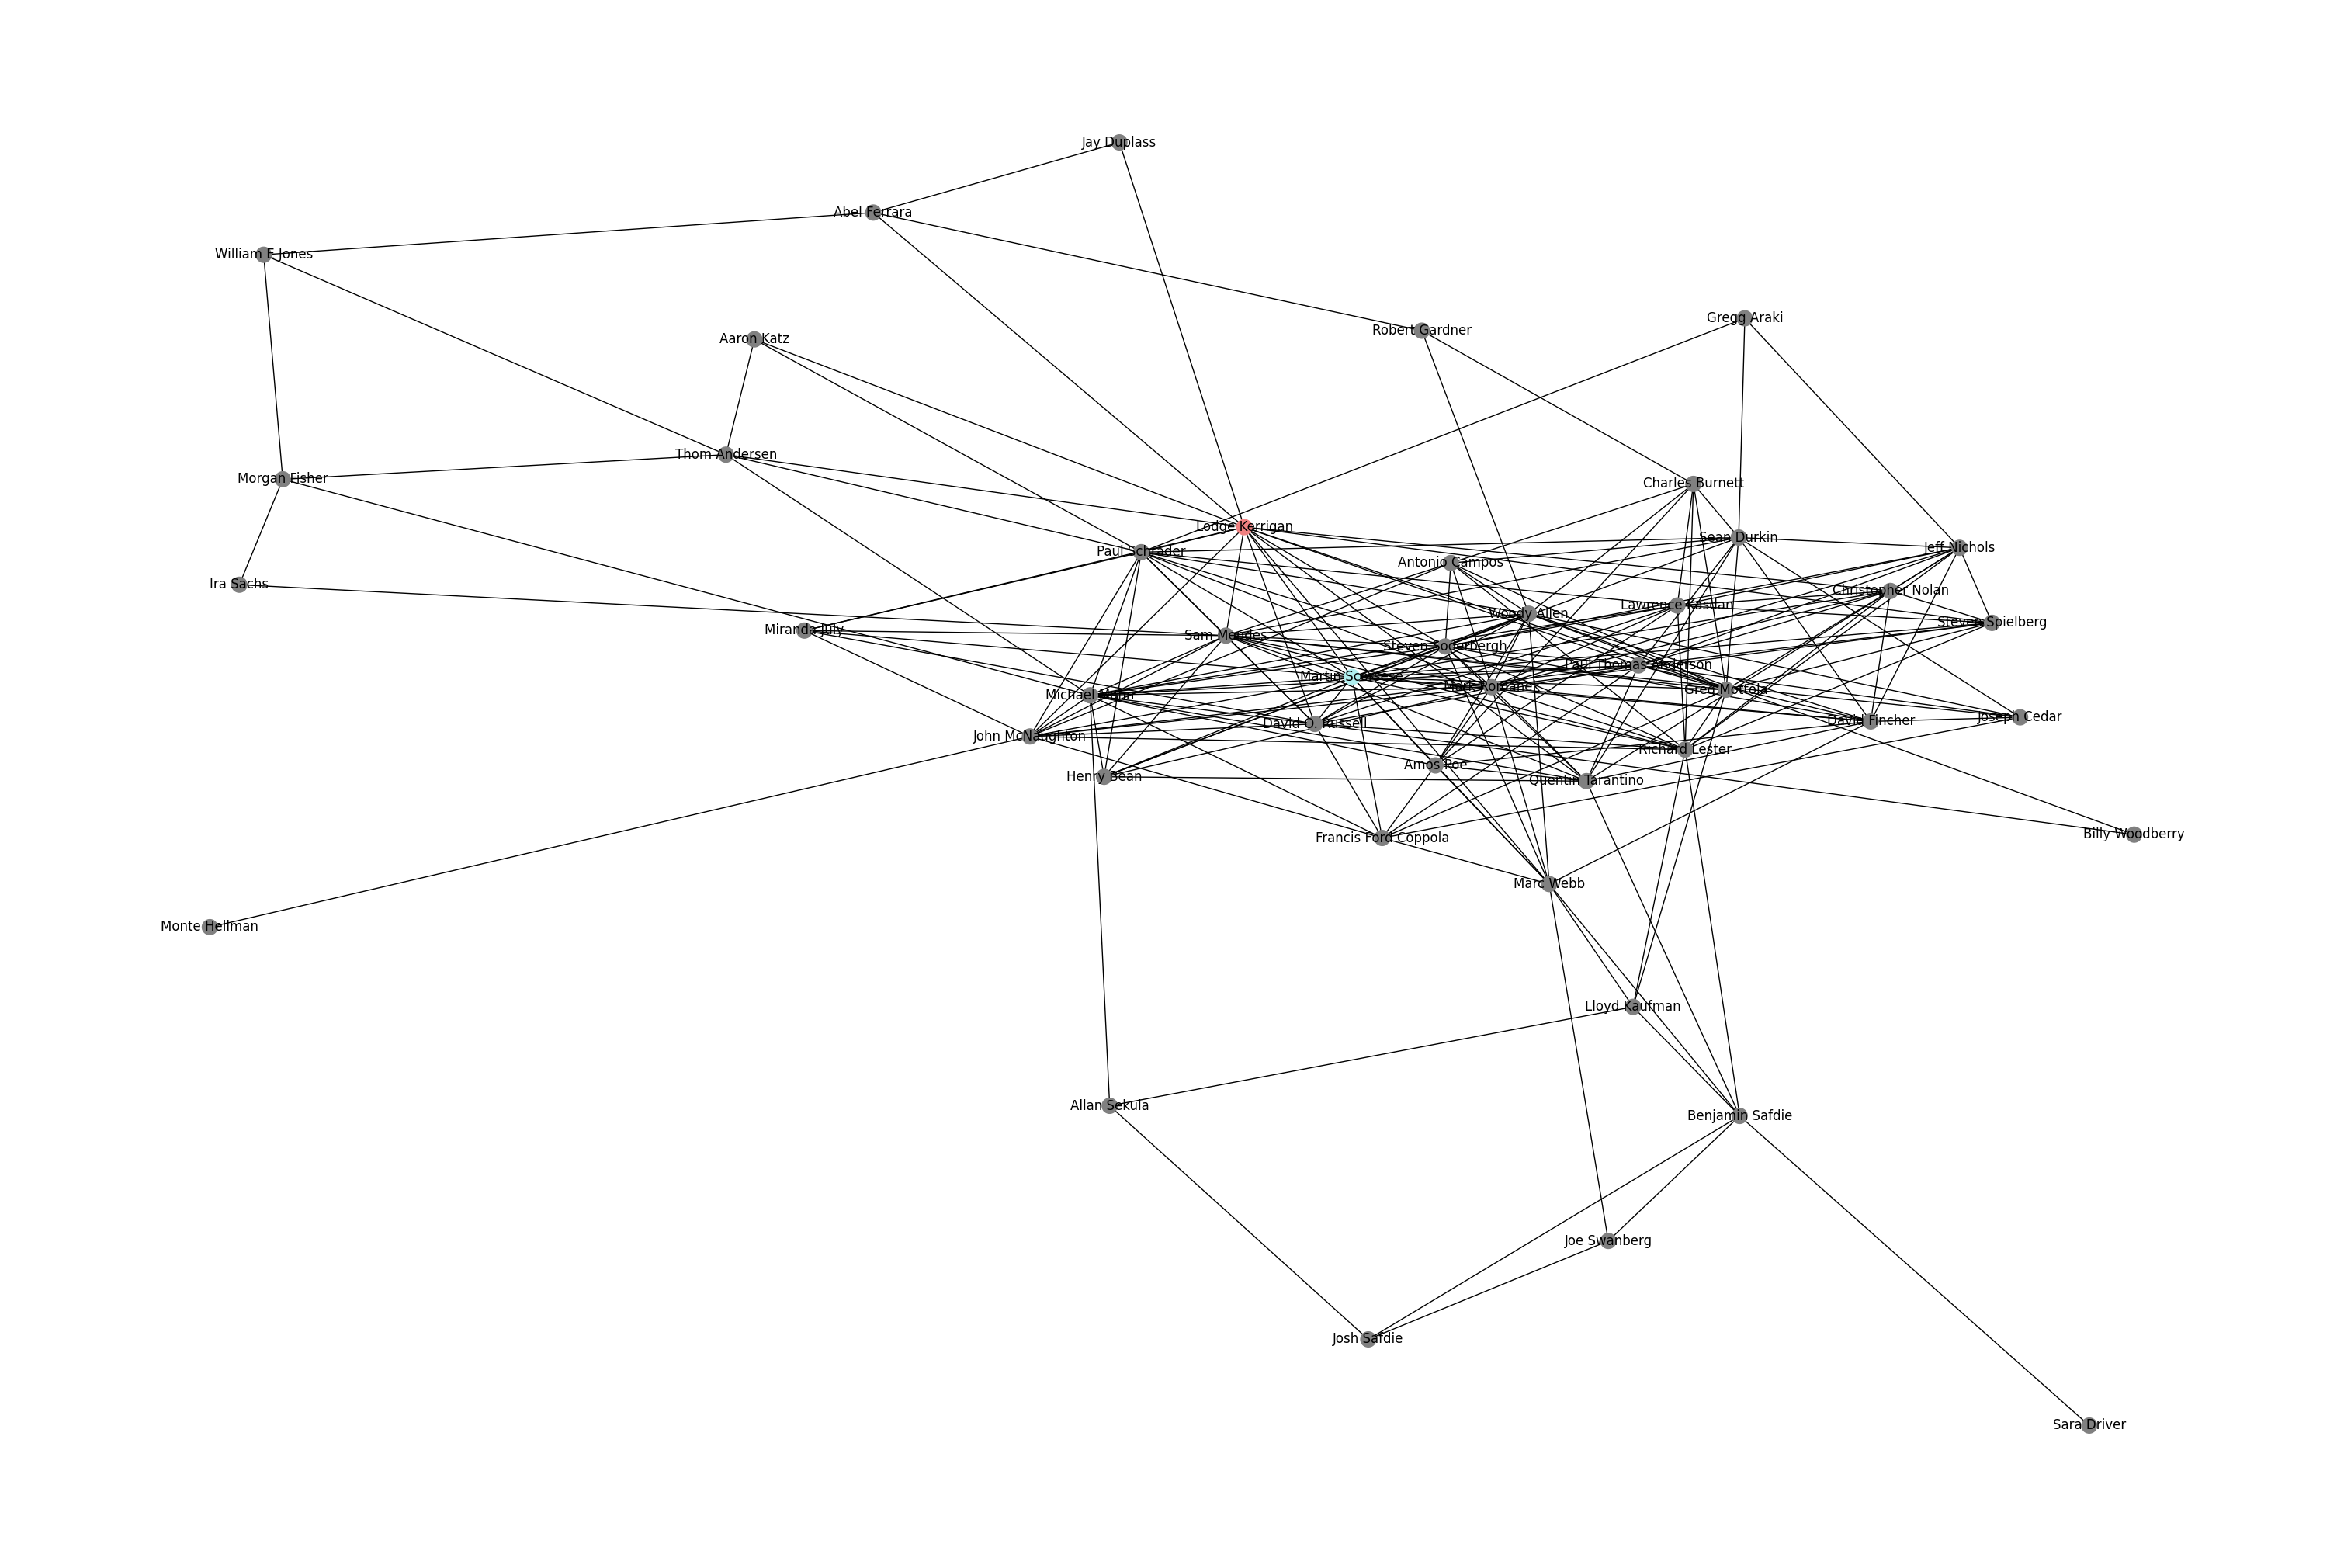

In [36]:
G2 = nx.Graph(matr_2)

centre_node = most_connected
connector_node = community_connector

node_colors = ['#AFEEEE' if node == centre_node 
               else '#F08080' if node == connector_node
               else 'grey' for node in G2.nodes()]  

plt.figure(figsize=(30, 20))
nx.draw(G2, node_size=200, with_labels=True, node_color=node_colors)
if not os.path.exists("../images"):
    os.makedirs("../images")
plt.savefig('../images/US_directors_network.png', dpi=300, bbox_inches='tight')

Weighted edges

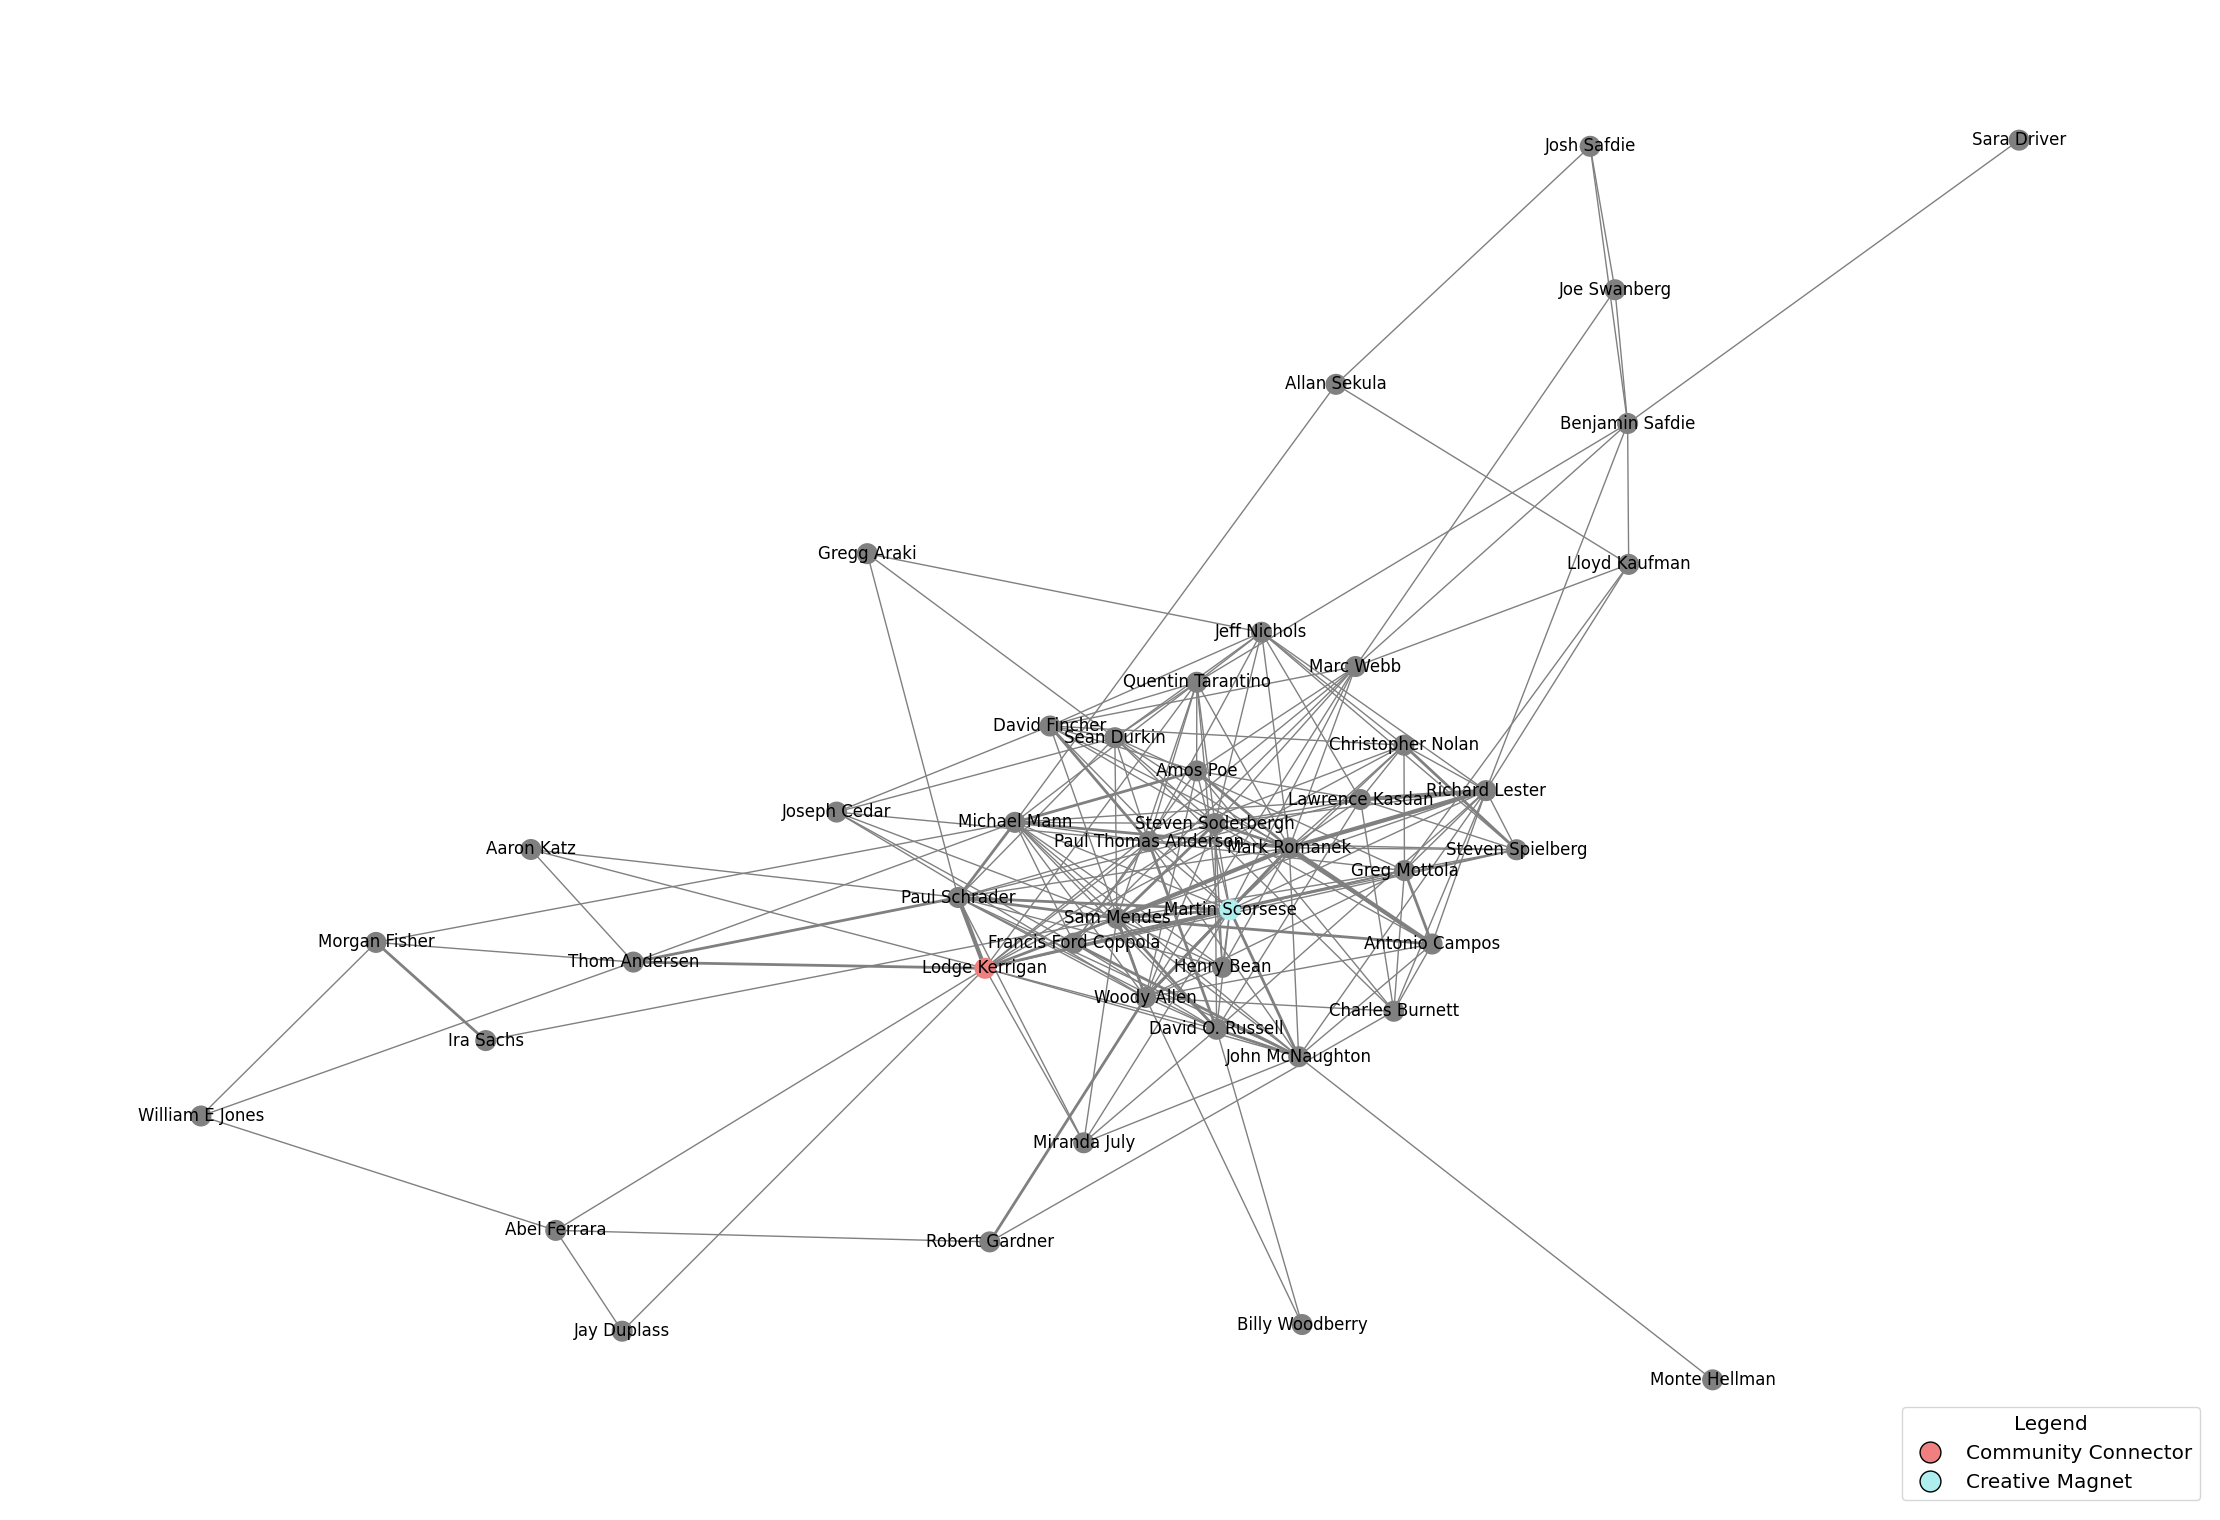

In [37]:
G2 = nx.Graph(matr_2)

centre_node = most_connected
connector_node = community_connector

node_colors = ['#AFEEEE' if node == centre_node 
               else '#F08080' if node == connector_node
               else 'grey' for node in G2.nodes()] 

# Extract edge weights for thickness
edge_weights = [G2[u][v].get('weight', 1) for u, v in G2.edges()]

plt.figure(figsize=(22, 15))
nx.draw(
    G2,
    node_size=200,
    with_labels=True,
    node_color=node_colors,
    width=edge_weights*2,  # Set edge thickness
    edge_color='gray'
)

# Create custom circular legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Community Connector',
           markerfacecolor='#F08080', markersize=15, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Creative Magnet',
           markerfacecolor='#AFEEEE', markersize=15, markeredgecolor='black')
]

plt.legend(
    handles=legend_elements,
    loc='lower right',
    fontsize='x-large',
    frameon=True,
    title="Legend",
    title_fontsize='x-large'
)

if not os.path.exists("../images"):
    os.makedirs("../images")
plt.savefig('../images/US_directors_network.png', dpi=300, bbox_inches='tight')


In [38]:
Directors_choice_US[most_connected]

[('2001: A Space Odyssey', 1968, 'Stanley Kubrick'),
 ('8½', 1963, 'Federico Fellini'),
 ('Ashes and Diamonds', 1958, 'Andrzej Wajda'),
 ('Citizen Kane', 1941, 'Orson Welles'),
 ('Leopard, The', 1963, 'Luchino Visconti'),
 ('Paisà', 1946, 'Roberto Rossellini'),
 ('Red Shoes, The', 1948, 'Michael Powell/Emeric Pressburger'),
 ('River, The', 1951, 'Jean Renoir'),
 ('Salvatore Giuliano', 1962, 'Francesco Rosi'),
 ('Searchers, The', 1956, 'John Ford'),
 ('Ugetsu Monogatari', 1953, 'Mizoguchi Kenji'),
 ('Vertigo', 1958, 'Alfred Hitchcock')]

Explanation: \
4 out of 10 movies in Scorsese's list are in top-5, but it's the rest of the movies that makes him well-connected with the fellow directors. 

In [39]:
Directors_choice_US[community_connector]

[('2001: A Space Odyssey', 1968, 'Stanley Kubrick'),
 ('Aguirre, Wrath of God', 1972, 'Werner Herzog'),
 ('Alice in the Cities', 1974, 'Wim Wenders'),
 ('Annie Hall', 1977, 'Woody Allen'),
 ('Fear Eats the Soul', 1974, 'Rainer Werner Fassbinder'),
 ('Pickpocket', 1959, 'Robert Bresson'),
 ('Taxi Driver', 1976, 'Martin Scorsese'),
 ('Tokyo Story', 1953, 'Ozu Yasujirô'),
 ('Vertigo', 1958, 'Alfred Hitchcock'),
 ('Woman Under the Influence, A', 1974, 'John Cassavetes')]